# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [ ]:
!pip install scprep

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [ ]:
import gdown
downloaded_file = 'data.pickle.gz'
file_id = '1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf'

url = 'https://drive.google.com/uc?id={}'.format(file_id)
gdown.download(url, downloaded_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf
To: /content/data.pickle.gz
100%|██████████| 75.4M/75.4M [00:02<00:00, 29.4MB/s]


'data.pickle.gz'

In [ ]:
# scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [ ]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [ ]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.36943157, ...,   0.17373117,
          0.52376667,  -0.65548867],
       [ -0.66863206,  13.21553128,  -4.89263862, ...,  -2.11168938,
         -0.55383667,   1.84363325],
       [  0.29665496,   6.85551504,  18.19106762, ...,   4.98062476,
         -3.06273534,  -0.17384843],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.1642067 , ...,  -2.86686577,
         -1.36976958,   0.39583071],
       [  3.13934964,  15.10619606,   3.69472761, ...,  -4.2960132 ,
          2.62762731,   0.12839158],
       [ 42.90597659,  -9.79281524, -13.25215036, ...,  -1.21068359,
          1.07742895,  -0.64846057]])

For easier classification, we'll scale the data to have mean 0 and standard deviation 1 across all features.

In [ ]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data

array([[-0.17060225,  1.43324626,  0.61033175, ...,  0.07795715,
         0.23569637, -0.29671596],
       [-0.03979573,  1.17501009, -0.68341445, ..., -0.94756333,
        -0.24922795,  0.83454594],
       [ 0.01765635,  0.60953277,  2.54096806, ...,  2.23492027,
        -1.37823891, -0.07869488],
       ...,
       [ 2.35163964, -0.72986086, -1.41975859, ..., -1.28642825,
        -0.61639989,  0.17917822],
       [ 0.18684824,  1.34311156,  0.51608762, ..., -1.9277194 ,
         1.18243916,  0.05811822],
       [ 2.55368378, -0.87069195, -1.85108931, ..., -0.54326142,
         0.48484584, -0.29353459]])

In [ ]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [ ]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [ ]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 50), (4311, 50))

## 3. Moving Our Data to PyTorch Tensors

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available.

In [ ]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [ ]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 50])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 50])
valid labels shape: torch.Size([4311])


## Tensor Operations 1

1. Create a tensor called x of values (0, 1, ..., 18, 19) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [ ]:
# create x using torch.arange()
x = torch.arange(20)

# reshape to (4,5)
x = x.reshape(4,5)

# add 5
y = x + 5

# power y to the 3rd power
z = y ** 3

# print the first row of z
print(z[0])

tensor([125, 216, 343, 512, 729])


## Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [ ]:
# Get the last five rows of `train_tensor`
data_last5 = train_tensor[-5:]

# Multiply by two
last5_double = data_last5 * 2

# Print the result
last5_double

tensor([[-4.2113e-01,  1.2117e+00,  2.1553e+00,  7.8266e-02,  3.1221e+00,
         -3.4544e+00,  2.6319e+00, -9.3447e-01,  1.4297e+00, -5.3985e+00,
          4.0124e+00, -1.2534e+00, -3.0794e-01, -1.2821e+00,  9.7887e-01,
          1.2146e+00,  1.6505e+00, -8.3091e-01, -1.0291e-01, -1.2853e+00,
          2.0174e+00, -4.0205e+00,  1.5819e+00, -2.1735e+00, -3.8777e+00,
          1.0103e+00,  2.0752e+00, -3.5995e+00, -1.0599e+00,  1.0131e+00,
         -1.8183e+00,  3.0743e+00,  3.0715e+00,  2.3305e+00,  2.6359e-01,
          1.6463e+00,  4.0438e-01, -4.1099e-01, -8.4309e-01, -1.9332e+00,
         -7.4490e-01, -2.0945e+00,  1.3472e+00, -2.3033e-01, -5.1761e-02,
          3.0062e-01,  1.0991e+00, -3.1652e+00,  5.5992e-01,  2.2994e+00],
        [-5.7734e-01,  2.0474e+00,  7.9776e-01, -1.3401e+00,  5.4539e-01,
         -2.8550e+00,  2.3354e+00,  6.9715e+00, -2.1537e-02, -9.6844e-01,
          6.3130e-01, -3.3526e+00, -3.1303e-02,  2.7343e-01, -2.1231e+00,
          2.5031e+00, -1.9558e+00,  3

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [ ]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [ ]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[2.8212e-10, 3.3734e-11, 3.3685e-26,  ..., 7.7343e-08, 5.1690e-09,
         1.5751e-02],
        [1.2083e-22, 6.3385e-10, 1.6579e-37,  ..., 8.7584e-09, 7.3830e-13,
         5.0718e-14],
        [5.0750e-20, 1.2225e-11, 2.1067e-32,  ..., 2.6489e-34, 2.9519e-04,
         1.5109e-15],
        ...,
        [1.9010e-11, 7.0329e-05, 3.1011e-19,  ..., 6.5159e-11, 5.2166e-04,
         8.2028e-07],
        [7.8649e-09, 5.5121e-04, 8.6153e-17,  ..., 2.2612e-09, 4.9162e-03,
         9.7847e-01],
        [4.5511e-11, 4.6233e-08, 1.3757e-21,  ..., 1.3421e-21, 4.4175e-01,
         1.6808e-05]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [ ]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [ ]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(229101.5373, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [ ]:
model = nn.Sequential(layer_1, layer_2)
print(model)

Sequential(
  (0): layer(
    (activation): ReLU()
  )
  (1): layer(
    (activation): Softmax(dim=-1)
  )
)


We can now obtain the output of our model by simply calling `model(data)`.

In [ ]:
model(train_tensor)

tensor([[2.8212e-10, 3.3734e-11, 3.3685e-26,  ..., 7.7343e-08, 5.1690e-09,
         1.5751e-02],
        [1.2083e-22, 6.3385e-10, 1.6579e-37,  ..., 8.7584e-09, 7.3830e-13,
         5.0718e-14],
        [5.0750e-20, 1.2225e-11, 2.1067e-32,  ..., 2.6489e-34, 2.9519e-04,
         1.5109e-15],
        ...,
        [1.9010e-11, 7.0329e-05, 3.1011e-19,  ..., 6.5159e-11, 5.2166e-04,
         8.2028e-07],
        [7.8649e-09, 5.5121e-04, 8.6153e-17,  ..., 2.2612e-09, 4.9162e-03,
         9.7847e-01],
        [4.5511e-11, 4.6233e-08, 1.3757e-21,  ..., 1.3421e-21, 4.4175e-01,
         1.6808e-05]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

#### Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [ ]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [ ]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:

            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))


                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 948.774 training accuracy: 0.419 validation accuracy: 0.228 
Step 100 loss: 907.063 training accuracy: 0.414 validation accuracy: 0.268 
Step 150 loss: 746.325 training accuracy: 0.450 validation accuracy: 0.360 
Step 200 loss: 365.822 training accuracy: 0.574 validation accuracy: 0.426 
Step 250 loss: 268.218 training accuracy: 0.609 validation accuracy: 0.505 
Step 300 loss: 296.387 training accuracy: 0.636 validation accuracy: 0.551 
Step 350 loss: 234.097 training accuracy: 0.705 validation accuracy: 0.615 
Step 400 loss: 147.943 training accuracy: 0.766 validation accuracy: 0.649 
Step 450 loss: 219.847 training accuracy: 0.659 validation accuracy: 0.663 
Step 500 loss: 161.730 training accuracy: 0.766 validation accuracy: 0.682 
Step 550 loss: 186.100 training accuracy: 0.752 validation accuracy: 0.695 
Step 600 loss: 193.422 training accuracy: 0.713 validation accuracy: 0.703 
Step 650 loss: 201.730 training accuracy: 0.750 validation accuracy: 0.712 
Step 700 loss

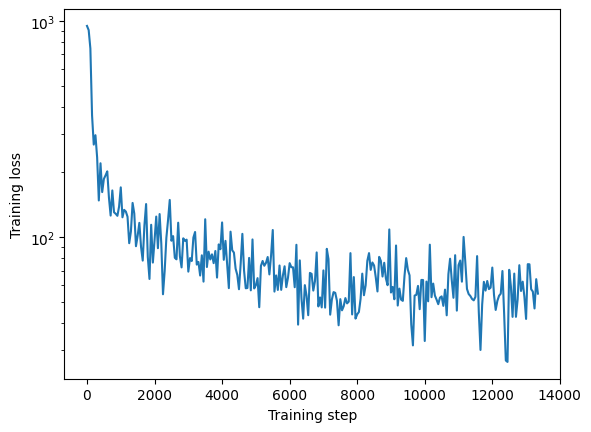

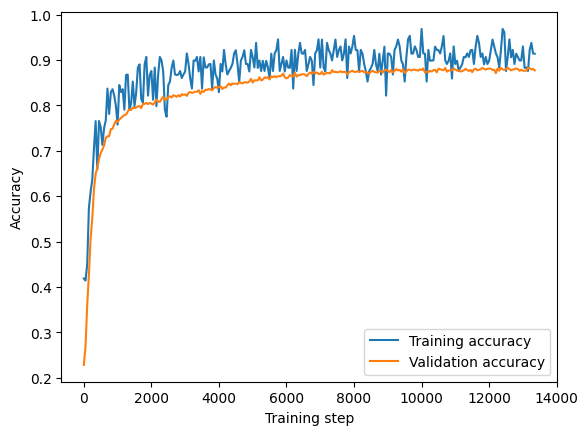

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Assignment 2a

1. How did our network do? Is the classification accuracy high?
Our network did good! our classification accuracy is over 87% but usually an accuracy is considered high when it is above 95%. Ours is still very good!
2. How many iterations did it take for the training accuracy to stop increasing?
We can graphicaly read that after 6000 training step, we are hitting a plateau
3. How many iterations did it take for the training loss to stop decreasing?:
The training loss stop decreasing between 7000 and 8000 step.
4. How many iterations did it take for the validation accuracy to stop increasing?
The validation accuracy stopped at around 7500 steps.

*italicized text*## Exercise  - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [ ]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 50
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:

            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))


                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1959.459 training accuracy: 0.318 validation accuracy: 0.276 
Step 100 loss: 1549.521 training accuracy: 0.422 validation accuracy: 0.359 
Step 150 loss: 1228.226 training accuracy: 0.550 validation accuracy: 0.405 
Step 200 loss: 969.498 training accuracy: 0.628 validation accuracy: 0.476 
Step 250 loss: 1052.973 training accuracy: 0.633 validation accuracy: 0.514 
Step 300 loss: 1058.354 training accuracy: 0.574 validation accuracy: 0.551 
Step 350 loss: 959.945 training accuracy: 0.628 validation accuracy: 0.568 
Step 400 loss: 845.090 training accuracy: 0.672 validation accuracy: 0.596 
Step 450 loss: 691.195 training accuracy: 0.736 validation accuracy: 0.604 
Step 500 loss: 557.309 training accuracy: 0.758 validation accuracy: 0.639 
Step 550 loss: 803.970 training accuracy: 0.690 validation accuracy: 0.661 
Step 600 loss: 474.370 training accuracy: 0.783 validation accuracy: 0.675 
Step 650 loss: 450.033 training accuracy: 0.781 validation accuracy: 0.673 
Step 700

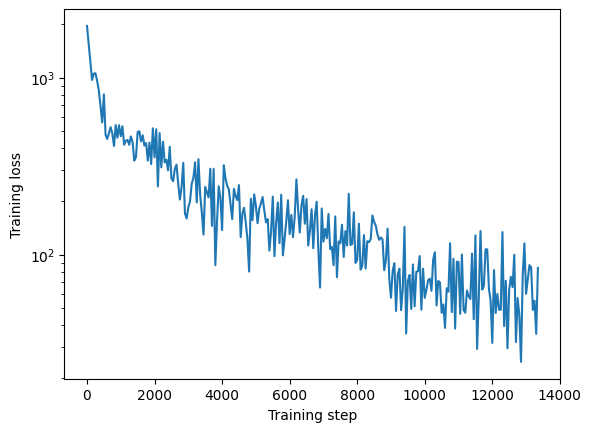

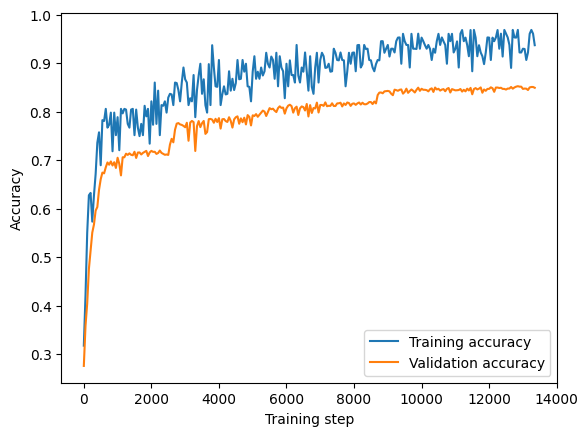

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise  - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [ ]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# create the optimizer
# List of optimizers to experiment with
optimizers = [
    ('SGD', optim.SGD),
    ('RMSprop', optim.RMSprop),
    ('Adagrad', optim.Adagrad),
    ('Adam', optim.Adam)
]
# =========

# train the network

def train_model(optimizer_name, optimizer_fn):
    print(f"Training with {optimizer_name}")

    # Reset model weights for a fair comparison
    model.apply(weight_reset)

    optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    step = 0
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
    }
    for epoch in range(n_epochs):
        # randomize the order in which we see the data in each epoch
        random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

        # iterate through the data in batches of size `batch_size`
        for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

            train_data_batch = train_tensor[batch_indices]
            train_labels_batch = train_labels[batch_indices]
            train_onehot = to_one_hot(train_labels_batch, num_classes)

            step += 1

            # get pass batch through layers
            output = model(train_data_batch)

            # compute cross entropy
            loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
            loss = -1 * loss.sum()

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()

            # evaluate accuracy on both the training and validation datasets
            if step % print_every == 0:

                # don't track gradients
                with torch.no_grad():
                    # compute the predicted outputs
                    train_prediction = output.argmax(1).numpy()

                    # compute the accuracy over the batch
                    acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                    # compute the loss on all the validation data
                    loss_np = []
                    output_np = []
                    labels_np = []

                    random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                        valid_data_batch = valid_tensor[batch_indices]
                        valid_labels_batch = valid_labels[batch_indices]

                        # pass through layers
                        valid_output = model(valid_data_batch)

                        # compute the predicted outputs

                        prediction_np = valid_output.argmax(1).numpy()

                        output_np.append(prediction_np.reshape(-1))
                        labels_np.append(valid_labels_batch.numpy().reshape(-1))


                    # compute the accuracy over the whole dataset
                    output_np = np.concatenate(output_np)
                    labels_np = np.concatenate(labels_np)
                    acc_validation = np.mean(output_np == labels_np)

                    results['train_loss'].append(loss.item())
                    results['train_acc'].append(acc_training)
                    results['val_acc'].append(acc_validation)
                    print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                        step, loss.item(), acc_training, acc_validation))
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Build the neural network model
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))
model = nn.Sequential(layer_1, layer_2)

# Train with different optimizers
for optimizer_name, optimizer_fn in optimizers:
    train_model(optimizer_name, optimizer_fn)

Training with SGD
Step 50 loss: 1591.997 training accuracy: 0.349 validation accuracy: 0.230 
Step 100 loss: 1197.364 training accuracy: 0.438 validation accuracy: 0.379 
Step 150 loss: 670.536 training accuracy: 0.628 validation accuracy: 0.488 
Step 200 loss: 510.061 training accuracy: 0.690 validation accuracy: 0.537 
Step 250 loss: 518.249 training accuracy: 0.688 validation accuracy: 0.569 
Step 300 loss: 432.929 training accuracy: 0.690 validation accuracy: 0.615 
Step 350 loss: 381.675 training accuracy: 0.729 validation accuracy: 0.621 
Step 400 loss: 338.694 training accuracy: 0.766 validation accuracy: 0.635 
Step 450 loss: 302.398 training accuracy: 0.760 validation accuracy: 0.663 
Step 500 loss: 263.274 training accuracy: 0.789 validation accuracy: 0.647 
Step 550 loss: 270.127 training accuracy: 0.729 validation accuracy: 0.685 
Step 600 loss: 286.038 training accuracy: 0.705 validation accuracy: 0.682 
Step 650 loss: 214.736 training accuracy: 0.812 validation accuracy: 

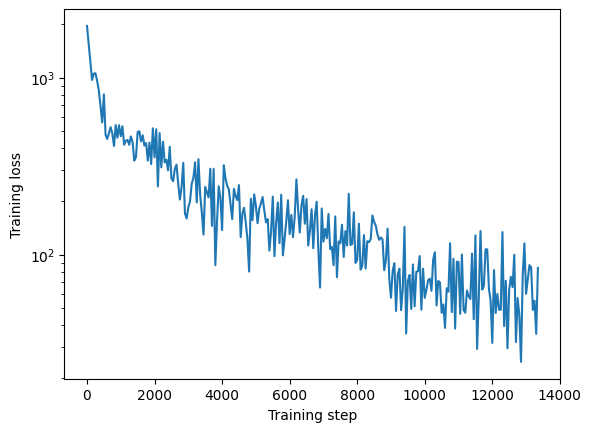

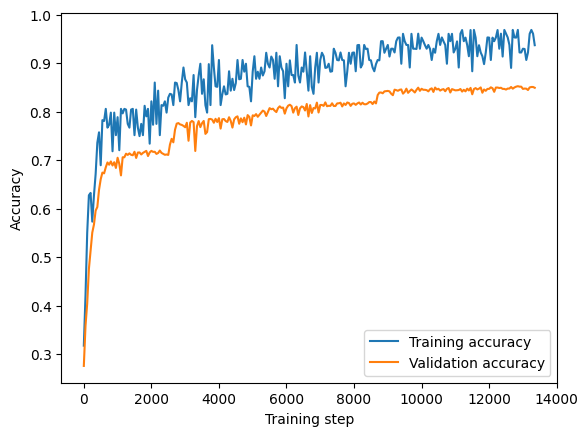

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

*italicized text*## Exercise  - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [ ]:
# Let's set some hyperparameters
batch_size = 128
learning_rate = 0.001  # Adjust the learning rate if needed
n_epochs = 100  # Increase epochs if the network hasn't finished improving after 100 epochs
print_every = 50

# Define the hidden layer sizes
num_hidden1 = 20  # First hidden layer
num_hidden2 = 15  # Second hidden layer (added)

# Build the neural network with two hidden layers
layer_1 = layer(input_size, num_hidden1, activation=nn.ReLU())
layer_2 = layer(num_hidden1, num_hidden2, activation=nn.ReLU())  # Additional hidden layer
layer_3 = layer(num_hidden2, num_classes, activation=nn.Softmax(dim=-1))

# Create the model
model = nn.Sequential(layer_1, layer_2, layer_3)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:

            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))


                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2899.729 training accuracy: 0.008 validation accuracy: 0.021 
Step 100 loss: 2767.430 training accuracy: 0.023 validation accuracy: 0.023 
Step 150 loss: 2720.903 training accuracy: 0.039 validation accuracy: 0.025 
Step 200 loss: 2630.977 training accuracy: 0.070 validation accuracy: 0.030 
Step 250 loss: 2348.251 training accuracy: 0.102 validation accuracy: 0.038 
Step 300 loss: 2303.464 training accuracy: 0.124 validation accuracy: 0.055 
Step 350 loss: 2138.422 training accuracy: 0.163 validation accuracy: 0.073 
Step 400 loss: 2232.074 training accuracy: 0.164 validation accuracy: 0.082 
Step 450 loss: 1849.964 training accuracy: 0.233 validation accuracy: 0.102 
Step 500 loss: 1860.922 training accuracy: 0.273 validation accuracy: 0.125 
Step 550 loss: 1845.549 training accuracy: 0.248 validation accuracy: 0.136 
Step 600 loss: 1820.116 training accuracy: 0.186 validation accuracy: 0.145 
Step 650 loss: 1789.139 training accuracy: 0.250 validation accuracy: 0.157 


In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise  - activation functions

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [ ]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network with different activation functions

# Using Tanh activation
layer_1_tanh = layer(input_size, num_hidden, activation=nn.Tanh())

# Using Sigmoid activation
layer_2_sigmoid = layer(num_hidden, num_hidden, activation=nn.Sigmoid())

# Using LeakyReLU activation
layer_3_leakyrelu = layer(num_hidden, num_classes, activation=nn.LeakyReLU())

# Or use any other activation from PyTorch documentation as per your experimentation

model = nn.Sequential(layer_1_tanh, layer_2_sigmoid, layer_3_leakyrelu)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:

            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))


                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise  - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [ ]:

# Hyperparameters
batch_size = 128
learning_rate = 0.0001
n_epochs = 500
print_every = 50
num_hidden = 20

def layer(input_dim, output_dim, activation=None):
    modules = [nn.Linear(input_dim, output_dim)]
    if activation is not None:
        modules.append(activation)
    return nn.Sequential(*modules)

# Building the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.LeakyReLU())

# Additional hidden layers
layer_2 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_3 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_4 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())
layer_5 = layer(num_hidden, num_hidden, activation=nn.LeakyReLU())

# Output layer
layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)

    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):

        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:

            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))


                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

In [ ]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Assignment

1. How did the more complex networks you built compare to the simple network we started with?
2. Which was more useful -- adding _depth_ to your network or adding width?
3. Which optimizer performed best?
4. What had the biggest effect on performance: depth, width, or optimizer?

#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.